In [44]:
!pip install sk-video

Check assigned GPU

In [45]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Feb 11 02:11:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

Check available memory

In [46]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [0]:
import skvideo.io  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator
import random
from numba import prange
import plotly.express as px
from sklearn.cluster import KMeans
import warnings 
from scipy import stats

warnings.filterwarnings("ignore")

In [48]:
video = skvideo.io.vread("/content/videoplayback.mp4")  
print(video.shape)

(1682, 360, 640, 3)


In [49]:
#Create Background Tensor
background = video[0].copy()
background.shape

(360, 640, 3)

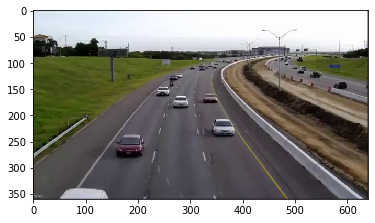

In [50]:
plt.imshow(background)
plt.show()

In [0]:
#Get random frames to speed up process
n_frames = 20
frames_idx = []
for i in range(0, n_frames):
  frames_idx.append(random.randint(0, video.shape[0]))

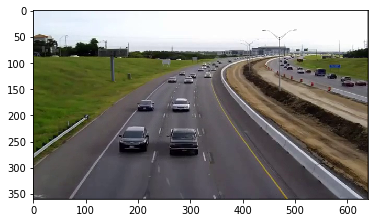

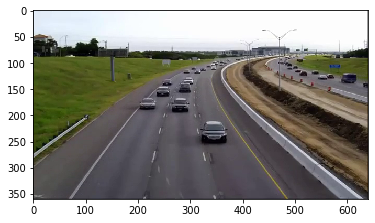

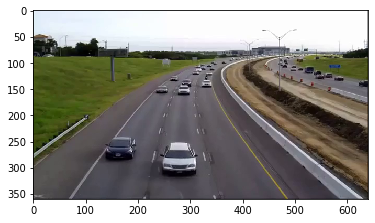

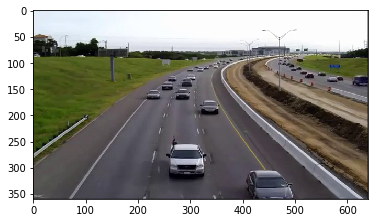

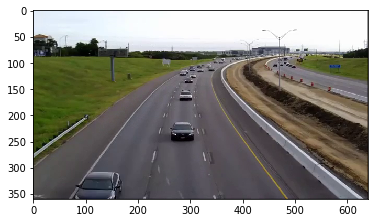

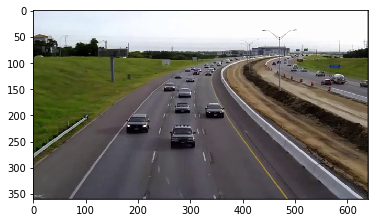

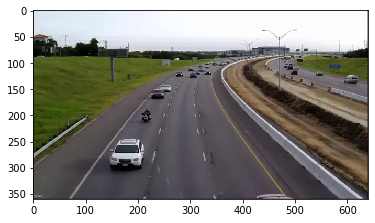

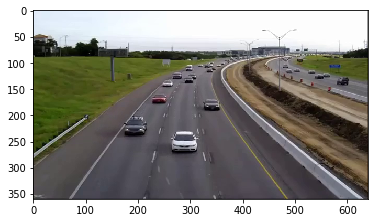

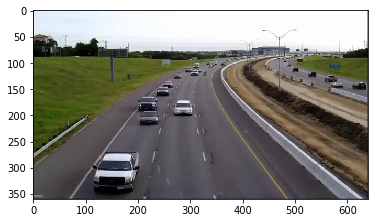

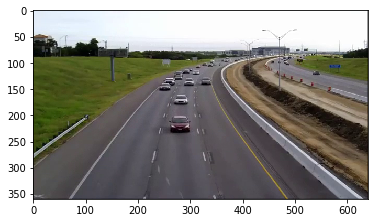

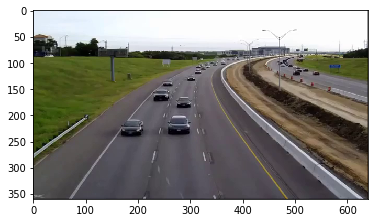

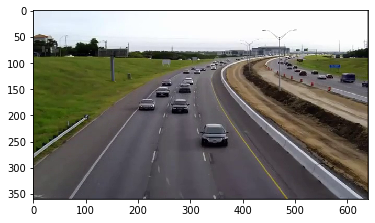

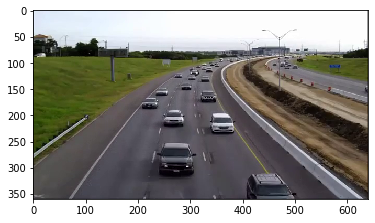

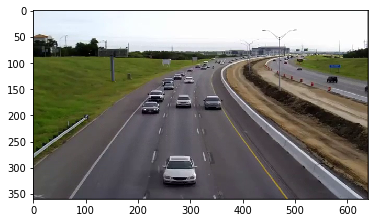

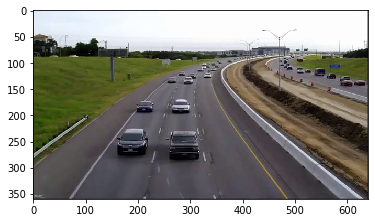

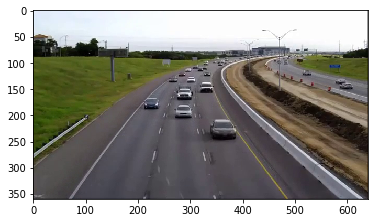

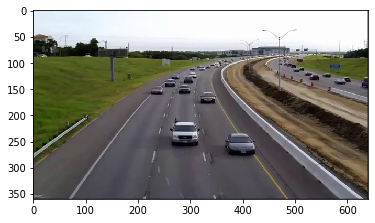

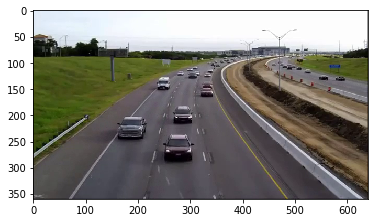

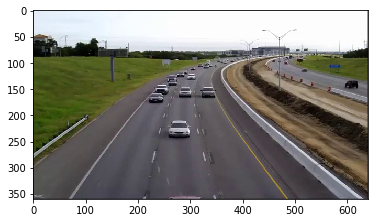

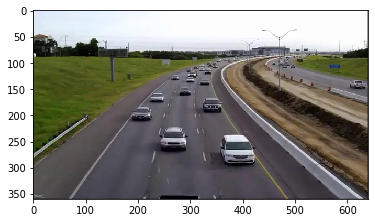

In [52]:
for frame in frames_idx:
  plt.imshow(video[frame])
  plt.show()

In [53]:
%%time
for x in prange(0, video.shape[2]):
  for y in prange(0, video.shape[1]):
    colors=[]
    for z in frames_idx:
      colors.append(video[z][y][x])
      colors_a = np.array(colors)
    ca = KMeans(n_clusters = 2)
    ca = ca.fit(colors)
    labels, counts = np.unique(ca.labels_, return_counts=True)
    clusters = dict(zip(labels, counts))
    most_common = max(clusters, key=clusters.get)
    #background_pixel = [int(i) for i in list(ca.cluster_centers_[most_common])]
    #background_pixel = list(stats.mode(colors_a[ca.labels_])[0][0])
    #background_pixel = list(np.median(colors_a[ca.labels_])[0])
    background_pixel = []
    background_pixel.append(np.median(colors_a[:,0]))
    background_pixel.append(np.median(colors_a[:,1]))
    background_pixel.append(np.median(colors_a[:,2]))
    background[y][x] = background_pixel

CPU times: user 2h 3min 39s, sys: 10.2 s, total: 2h 3min 49s
Wall time: 2h 3min 48s


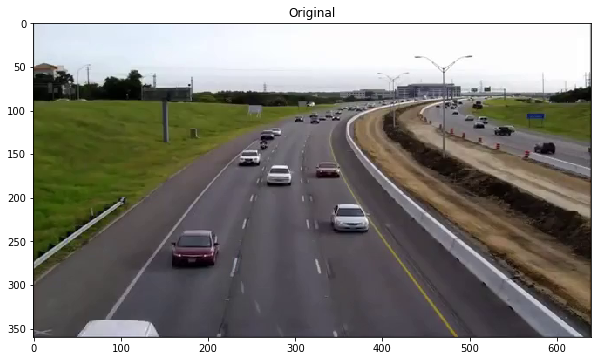

In [60]:
plt.figure(figsize=(10,10))
plt.imshow(video[0])
plt.title("Original")
plt.show()

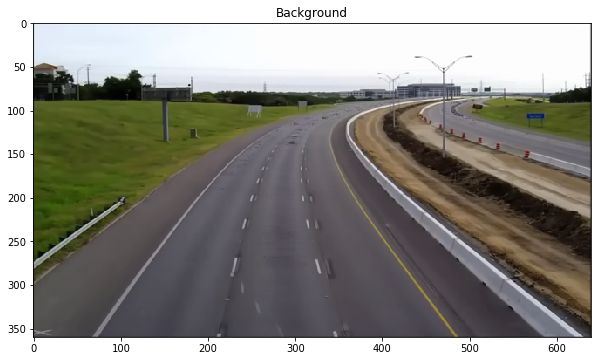

In [61]:
plt.figure(figsize=(10,10))
plt.imshow(background)
plt.title("Background")
plt.show()

In [0]:
video[0] = video[0].astype("int64")
background = background.astype("int64")

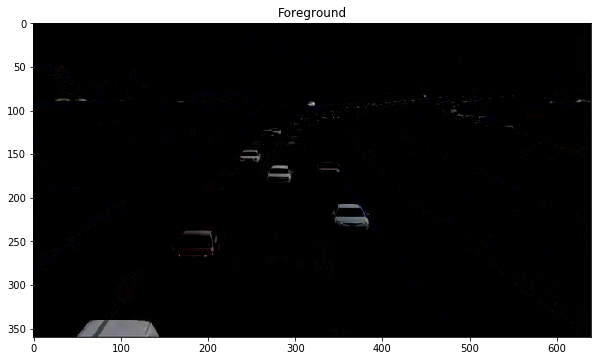

In [57]:
foreground = (video[0] - background)
np.clip(foreground, 0, 255, out=foreground)
plt.figure(figsize=(10,10))
plt.imshow(foreground)
plt.title("Foreground")
plt.show()

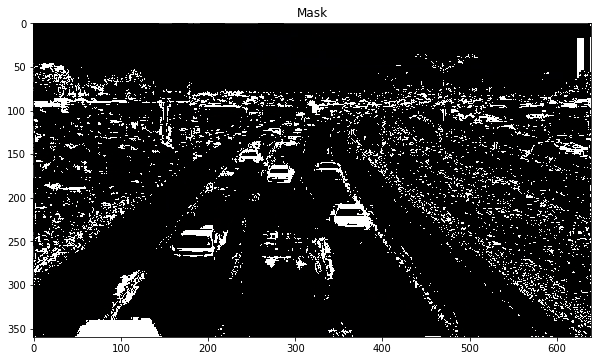

CPU times: user 2.05 s, sys: 5 ms, total: 2.06 s
Wall time: 2.06 s


In [58]:
%%time
mask = foreground.copy()
for x in prange(0, mask.shape[1]):
  for y in prange(0, mask.shape[0]):
    if np.mean(mask[y][x]) > 1:
      mask[y][x] = [255,255,255]
plt.figure(figsize=(10,10))
plt.imshow(mask)
plt.title("Mask")
plt.show()

In [59]:
pixel = pd.DataFrame(colors, columns=["R","G","B"])
pixel["label"] = ca.labels_
fig = px.scatter_3d(pixel, x = "R", y = "G", z = "B", color="label")
fig.show()